In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import iSDR_cython as ciSDR
np.random.seed(12)

In this notebook, we show an example on how to run eISDR and its old version iSDR that is presented in:
    
    (1) Brahim Belaoucha, Théodore Papadopoulo. Large brain effective network from EEG/MEG data and dMR information. PRNI 2017 – 7th International Workshop on Pattern Recognition in NeuroImaging, Jun 2017, Toronto, Canada.

    (2) Brahim Belaoucha, Mouloud Kachouane, Théodore Papadopoulo. Multivariate Autoregressive Model Constrained by Anatomical Connectivity to Reconstruct Focal Sources. 2016 38th Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC), Aug 2016, Orlando, United States. 2016.

We show how you can run both using real and synthetic data

# Define sensor and source space

In [2]:
n_t = 200
n_c, n_s = 3,3
np.random.seed(40)
G = np.abs(np.random.normal(0,1,(n_c, n_s)))
J = np.zeros((n_s, n_t))
J[:3, 0] = [10, 0.1, 0]
A = np.array([[0.9,-0.4,0], [0.25, 0.97,0],[0.5,0,0.5]])
for i in range(J.shape[-1]-1):
    J[:3, i+1] = np.dot(A, J[:3, i])

print(A)


[[ 0.9  -0.4   0.  ]
 [ 0.25  0.97  0.  ]
 [ 0.5   0.    0.5 ]]


# Ground truth

(0, 200)

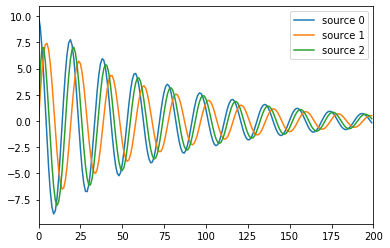

In [3]:
plt.plot(J.T)
plt.legend(['source %s'%s for s in range(n_s)])
plt.xlim(0, n_t)

# Define the structural connectivity

In [4]:
SC = np.array([[1,1,1], [1,1,0],[1,0,1]])
print( SC)

[[1 1 1]
 [1 1 0]
 [1 0 1]]


# Example 1: eiSDR order 1

## Generate EEG/MEG data

In [5]:
m_p = 1
M = np.dot(G, J[:, m_p:])

## Run eiSDR

In [6]:
cl = ciSDR.linear_model.iSDR(l21_ratio=0.001, la=[1e-2, 0.5], verbose=1, old_version=0)
cl.solver(G, M, SC, nbr_iter=10, model_p=1, A=np.eye(n_s), S_tol=1e-3)
R = cl.coef_

Iteration 0: nbr of active sources 3
Iteration 1: nbr of active sources 3
Stopped at iteration 1 : Change in active set tol 3.0000 > 3.0000  


## Get eigenvalues of MVAR model

In [7]:
cl.get_phi()
cl.eigs

,real,imag
eig,,
eig_0,0.485930,0.000000
eig_1,0.934862,0.312389
eig_2,0.934862,-0.312389


## Plot effective connectivity

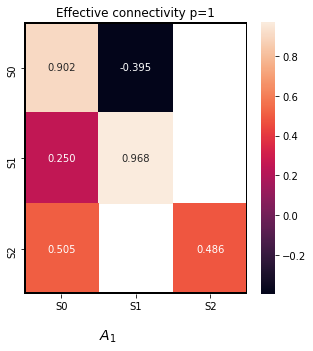

In [8]:
cl.plot_effective()

## Reconstruct the brain activation

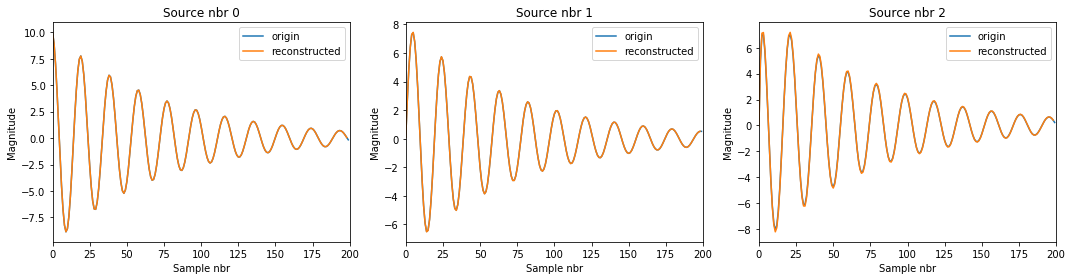

In [9]:
plt.figure(figsize=(15,4))
for i in range(n_s):
    plt.subplot(1,n_s, i+1)
    plt.plot(J[i, :], label='origin')
    if i < R.shape[0]:
        plt.plot(R[i, m_p-1:], label='reconstructed')
    plt.title('Source nbr %s'%i)
    plt.xlim(0, J.shape[1])
    plt.xlabel('Sample nbr')
    plt.ylabel('Magnitude')
    plt.legend()
plt.tight_layout()

## Reconstruct the brain activation using the estimated MVAR model

In [10]:
for i in range(m_p, n_t - m_p):
    R[:, i] = 0
    x = R.shape[0]
    for j in range(m_p):
        R[:, i] += np.dot(cl.Acoef_[:, j*x:(j+1)*x], R[:, i - m_p + j]) 

(0, 200)

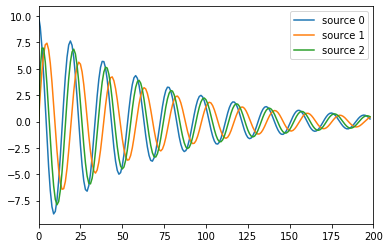

In [11]:
plt.plot(R.T)
plt.legend(['source %s'%s for s in cl.active_set[-1]])
plt.xlim(0, n_t)

# Example 2: eiSDR order 3

## Initialize MVAR model

In [12]:
m_p = 3
Atmp = np.zeros((n_s, n_s*m_p))
Atmp[:, -n_s:] = np.eye(n_s)

## Run eiSDR

In [13]:
cl = ciSDR.linear_model.iSDR(l21_ratio=0.001, la=[1e-4, 1.], verbose=True, old_version=0)
cl.solver(G, M, SC, nbr_iter=10, model_p=m_p, A=Atmp)
R = cl.coef_

Iteration 0: nbr of active sources 3
Iteration 1: nbr of active sources 3
Stopped at iteration 1 : Change in active set tol 3.0000 > 3.0000  


/Users/EEALBRB/workspace/iSDR_cython/src/iSDR_cython/linear_model.py:178: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6967552525394511, tolerance: 0.025333424398150353
  self.verbose)


## Compute eigenvalues of MVAR model

In [14]:
cl.get_phi()
cl.eigs

,real,imag
eig,,
eig_0,0.836154,0.499268
eig_1,0.836154,-0.499268
eig_2,-0.011517,0.997317
eig_3,-0.011517,-0.997317
eig_4,0.330816,0.780891
eig_5,0.330816,-0.780891
eig_6,-0.837165,0.501948
eig_7,-0.837165,-0.501948
eig_8,-0.759696,0.000000


## Plot effective connectivity

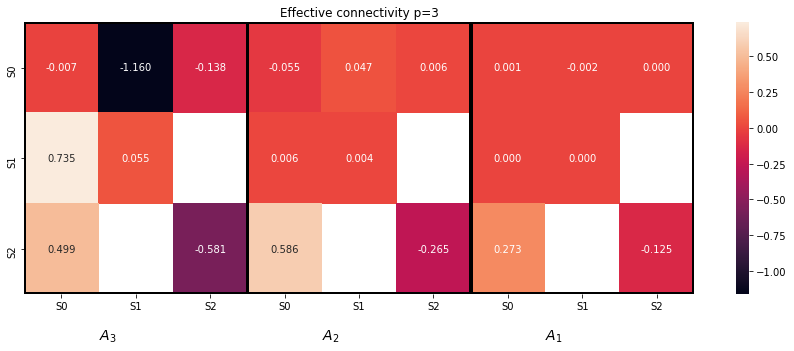

In [15]:
cl.plot_effective()

## Reconstruct the brain activation

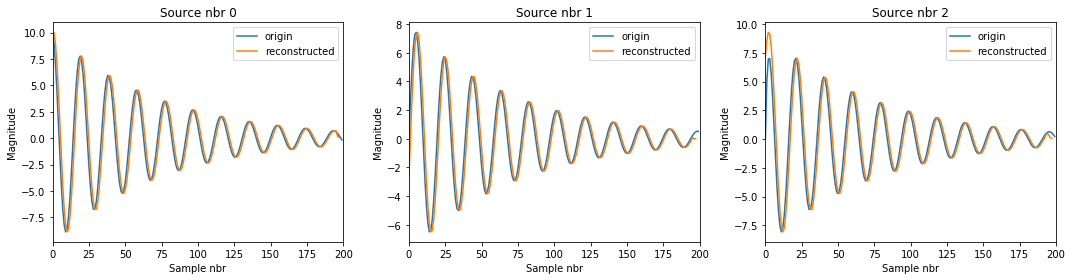

In [16]:
plt.figure(figsize=(15,4))
for i in range(n_s):
    plt.subplot(1,n_s, i+1)
    plt.plot(J[i, :], label='origin')
    if i < R.shape[0]:
        plt.plot(R[i, m_p:], label='reconstructed')
    plt.title('Source nbr %s'%i)
    plt.xlim(0, J.shape[1])
    plt.xlabel('Sample nbr')
    plt.ylabel('Magnitude')
    plt.legend()
plt.tight_layout()

## Reconstruct the brain activation using the estimated MVAR model

In [17]:
for i in range(m_p, R.shape[1]):
    R[:, i] = 0
    x = R.shape[0]
    for j in range(m_p):
        R[:, i] += np.dot(cl.Acoef_[:, j*x:(j+1)*x], R[:, i - m_p + j]) 

(0, 200)

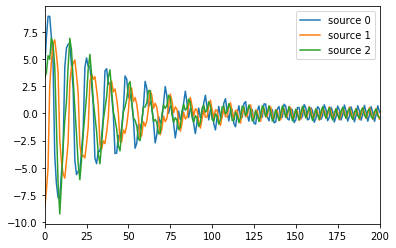

In [18]:
plt.plot(R.T)
plt.legend(['source %s'%s for s in cl.active_set[-1]])
plt.xlim(0, n_t)

# Cross-validation eiSDR:  grid-search

## Load eiSDRcv

In [19]:
from iSDR_cython import linear_model

In [20]:
clf = linear_model.iSDRcv(l21_values=[10**-i for i in range(-1, 6, 1)],
                          la_values=[10**-i for i in range(-1, 5,1)], la_ratio_values=[1, 0.5, 0.75, 0.25],
                          normalize=[0, 1],
                          model_p=[1,2,3],
                         old_version=False)

## Created random folder

In [21]:
clf.foldername

'/tmp/tmp_7cb916b4-34f8-4e54-9906-24516f9686d5'

## Run grid cross validation

In [22]:
clf.run(G, M, SC)

Successfully created the directory /tmp/tmp_7cb916b4-34f8-4e54-9906-24516f9686d5 


  0%|          | 0/1008 [00:00<?, ?it/s]/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.429637609254513, tolerance: 2.1838941718845515
  positive)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.204382240808229, tolerance: 2.1838941718845515
  positive)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4732828684142873, tolerance: 2.1838941718845515
  positive)
  0%|          | 1/1008 [00:00<16:07,  1.04it/s]/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coord

/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.01347228163482, tolerance: 2.1838941718845515
  positive)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5938999945426113, tolerance: 2.0409378642238707
  positive)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.50269728581753, tolerance: 2.1838941718845515
  positive)
 29%|██▉       | 292/1008 [00:20<01:35,  7.50it/s]/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarni

/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10204.689321119353, tolerance: 2.0409378642238707
  positive)
 57%|█████▋    | 575/1008 [00:34<00:23, 18.57it/s]/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.977329323715338, tolerance: 2.0409378642238707
  positive)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10203.771987667351, tolerance: 2.0409378642238707
  positive)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWar

/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.977329323715338, tolerance: 2.0409378642238707
  positive)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103.32772319698107, tolerance: 2.1838941718845515
  positive)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: RuntimeWarning: overflow encountered in square
 

Successfully deleted the directory /tmp/tmp_7cb916b4-34f8-4e54-9906-24516f9686d5


## Results

In [23]:
df = clf.results

In [24]:
df.Obj.min()

0.006361266138863564

## Parameters resulting to smallest Obj

In [25]:
x  = df[df.Obj == df.Obj.min()]

In [26]:
x

,rms,nbr,S_prior,A_prior_l1,A_prior_l2,ls_reg,la_reg_a,la_reg_r,p,normalize,l21_real,Obj
459,0.001786,3,116.266216,3.550937,2.500115,0.00001,0.0001,0.25,1,0,0.000038,0.006361


## Reconstruct with optimal parameters

In [27]:
cl = ciSDR.linear_model.iSDR(l21_ratio=x.ls_reg.values[0], la=[x.la_reg_a.values[0], x.la_reg_r.values[0]],
                             old_version=False)
cl.solver(G, M, SC, nbr_iter=10, model_p=x.p.values[0], A=np.eye(n_s))
R = cl.coef_

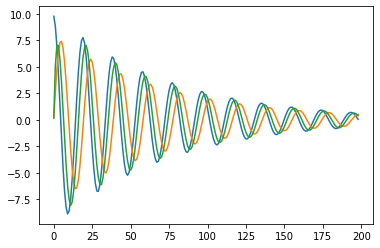

In [28]:
plt.plot(cl.coef_.T)

## Reconstructed effective connectivity

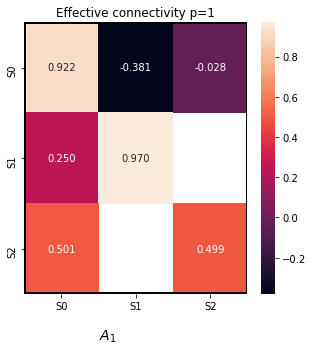

In [29]:
cl.plot_effective()

## Reconstructed dynamics

In [30]:
cl.get_phi()
cl.eigs

,real,imag
eig,,
eig_0,0.521861,0.000000
eig_1,0.934929,0.314296
eig_2,0.934929,-0.314296


# Real data

We are using EEG data acquired during famous face recognition task. we should see an activation around 170 ms in the fusiform area

In [31]:
from scipy.io import loadmat

In [32]:
data = loadmat('S1_p1_EEGT800.mat')

In [33]:
fs = 1/np.diff(data['time'])[0][0]

## L1 prior on MVAR

In [34]:
cl = ciSDR.linear_model.iSDR(l21_ratio=5, la=[1e-11, 1], verbose=1, old_version=False)
cl.solver(data['G'], data['M']*1e12, data['SC'].astype(int), model_p=2, A=None, normalize=False)
R = cl.coef_*1e-12

Iteration 0: nbr of active sources 562
Iteration 1: nbr of active sources 95
Iteration 2: nbr of active sources 57
Iteration 3: nbr of active sources 51
Iteration 4: nbr of active sources 49
Iteration 5: nbr of active sources 48
Iteration 6: nbr of active sources 43
Iteration 7: nbr of active sources 42
Iteration 8: nbr of active sources 41
Iteration 9: nbr of active sources 38
Iteration 10: nbr of active sources 37
Iteration 11: nbr of active sources 35
Stopped at iteration 11 : Change in active set tol 35.0000 > 35.0000  


### Brain reconstruction

Text(0.5, 1.0, 'Reconstructed brain activation')

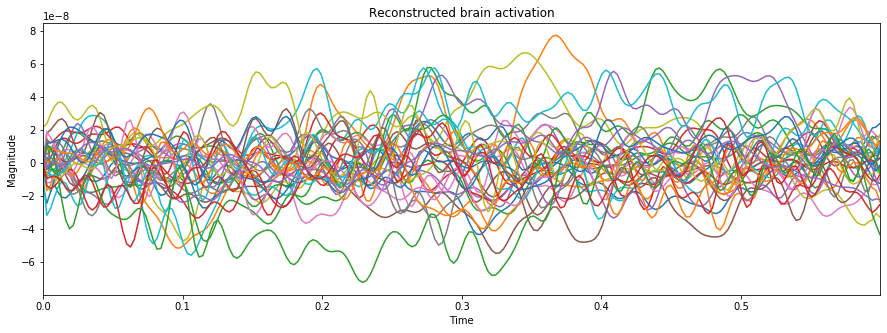

In [35]:
time = [i/fs for i in range(R.shape[1])]
plt.figure(figsize=(15,5))
plt.plot(time, R.T);
plt.xlim([time[0], time[-1]])
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Reconstructed brain activation')

### Effective connectivity (Sparse)

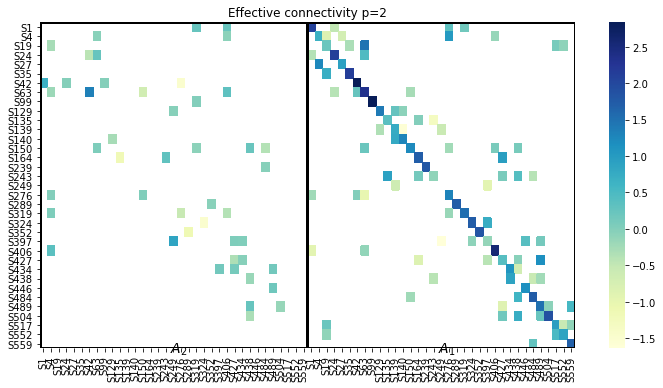

In [36]:
cl.plot_effective(fig_size=6, annot=False, cmap="YlGnBu")

### Left fusiform area

In [37]:
ix = np.where(cl.active_set[-1] == 42)[0][0]

Text(0, 0.5, 'Magnitude')

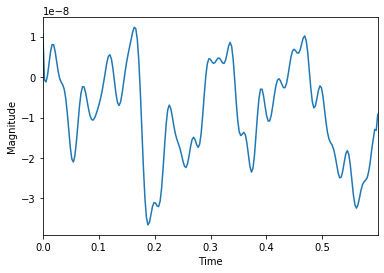

In [38]:
plt.plot(time, 1e-12*cl.coef_[ix, :])
plt.xlim([time[0], time[-1]])
plt.xlabel('Time')
plt.ylabel('Magnitude')

## L2 prior on MVAR

In [39]:
cl = ciSDR.linear_model.iSDR(l21_ratio=5, la=[1e-12, 0], verbose=1, old_version=False)
cl.solver(data['G'], data['M']*1e12, data['SC'].astype(int), model_p=2, A=None, normalize=False)
R = cl.coef_*1e-12

Iteration 0: nbr of active sources 562


/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.377607432637524e-05, tolerance: 4.99568133707321e-08
  positive)


Iteration 1: nbr of active sources 95


/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0369804250267603e-05, tolerance: 4.99568133707321e-08
  positive)


Iteration 2: nbr of active sources 79


/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.015424684140376e-05, tolerance: 4.99568133707321e-08
  positive)


Iteration 3: nbr of active sources 77


/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.728625610218881e-05, tolerance: 4.99568133707321e-08
  positive)


Iteration 4: nbr of active sources 71


/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.472201343362785e-05, tolerance: 4.99568133707321e-08
  positive)


Iteration 5: nbr of active sources 70


/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.623692666969983e-05, tolerance: 4.99568133707321e-08
  positive)


Iteration 6: nbr of active sources 68


/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.793001982289589e-05, tolerance: 4.99568133707321e-08
  positive)


Iteration 7: nbr of active sources 65


/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.054896203345034e-05, tolerance: 4.99568133707321e-08
  positive)


Iteration 8: nbr of active sources 63
Stopped at iteration 8 : Change in active set tol 63.0000 > 63.0000  


### Brain activation reconstruction

Text(0.5, 1.0, 'Reconstructed brain activation')

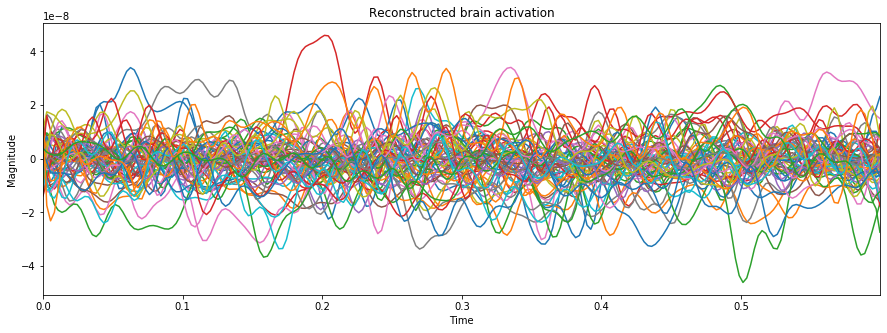

In [40]:
time = [i/fs for i in range(R.shape[1])]
plt.figure(figsize=(15,5))
plt.plot(time, R.T);
plt.xlim([time[0], time[-1]])
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Reconstructed brain activation')

### Effective connectivity (less sparse) 

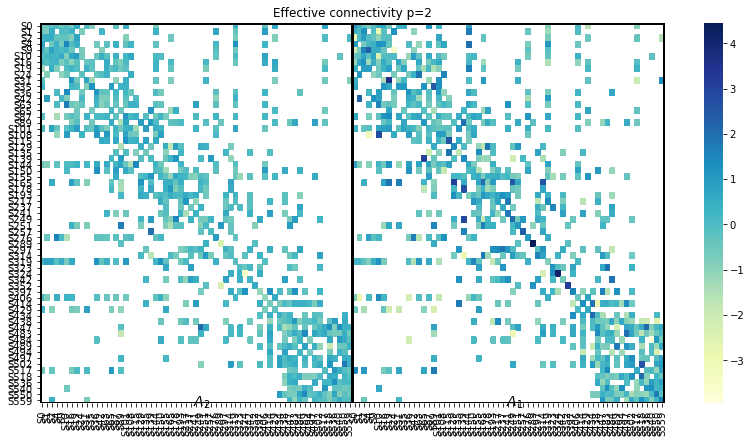

In [41]:
cl.plot_effective(fig_size=7, annot=False, cmap="YlGnBu")

### Left fusiform area

In [42]:
ix = np.where(cl.active_set[-1] == 42)[0][0]

Text(0, 0.5, 'Magnitude')

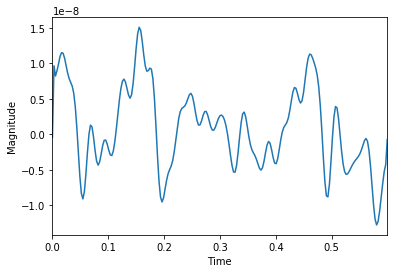

In [43]:
plt.plot(time, 1e-12*cl.coef_[ix, :])
plt.xlim([time[0], time[-1]])
plt.xlabel('Time')
plt.ylabel('Magnitude')

# Example on how to run iSDR

You can use the iSDR EEG/MEG source reconstruction by setting the 'old_version' to True

In [44]:
cl = ciSDR.linear_model.iSDR(l21_ratio=x.ls_reg.values[0], la=[x.la_reg_a.values[0], x.la_reg_r.values[0]],
                             old_version=True)
cl.solver(G, M, SC, model_p=x.p.values[0], A=np.eye(n_s))
R = cl.coef_

/Users/EEALBRB/workspace/iSDR_cython/src/iSDR_cython/linear_model.py:239: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(G, yt)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)


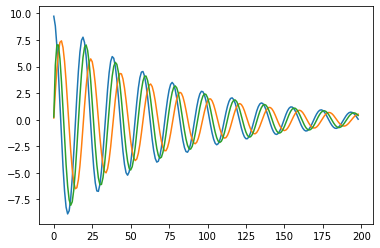

In [45]:
plt.plot(R.T)

In [46]:
cl.get_phi()

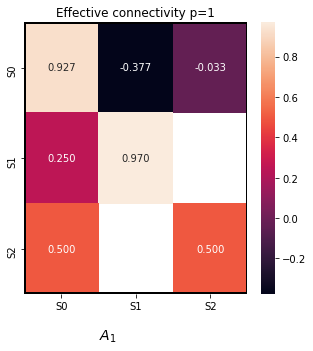

In [47]:
cl.plot_effective()